# Multi Output GPs in GPflow

$
\newcommand{\GP}{\mathcal{GP}}
\newcommand{\NN}{\mathcal{N}}
\newcommand{\LL}{\mathcal{L}}
\newcommand{\RR}{\mathbb{R}}
\newcommand{\EE}{\mathbb{E}}
\newcommand{\valpha}{\boldsymbol\alpha}
\newcommand{\vf}{\mathbf{f}}
\newcommand{\vF}{\mathbf{F}}
\newcommand{\vg}{\mathbf{g}}
\newcommand{\vW}{\mathbf{W}}
\newcommand{\vI}{\mathbf{I}}
\newcommand{\vZ}{\mathbf{Z}}
\newcommand{\vu}{\mathbf{u}}
\newcommand{\vU}{\mathbf{U}}
\newcommand{\vX}{\mathbf{X}}
\newcommand{\vY}{\mathbf{Y}}
\newcommand{\identity}{\mathbb{I}}
$
- $X \in \mathbb{R}^{N \times D}$ the input
- $Y \in \RR^{N \times P}$ the output
- $k_{1..L}$, $L$ kernels on $\RR^{N \times D}$
- $g_{1..L}$, $L$ independent $\GP$s  with $g_l \sim \GP(0,k_l)$
- $f_{1..P}$, $P$ correlated  $\GP$s  with $\vf = \vW \vg$ 

### Multi Output Kernels class diagram
![new_multioutput_gp_kernels.png](./new_multioutput_gp_kernels.png)




### Multi Output Features class diagram

![new_multioutput_gp_features.png](./new_multioutput_gp_features.png)

### Shape of Kuu and Kuf and the underlying conditional code depends on Mof and Mok classes used

| Feature                | Kernel                        | Kuu           | Kuf           | conditional                     | note                                                                                                                                                                                                            |
|------------------------|-------------------------------|---------------|---------------|---------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| InducingPoints         | Mok  | MxPxMxP | MxPxNxP | fully_correlated_conditional    | This is the default. Will be very inefficient for certain kernels. In this case q_mu and q_sqrt are 1 x MP and 1 x MP x MP                                                                                                                                              |
| SharedIndependentMof   | SharedIndependentMok          | M x M         | M x N         | base_conditional                | These two classes are in a sense redundant as we can achieve the same behaviour using the single output Kernel and InducingFeature classes. They are added for illustrative purposes. But thanks to the conditinal dispatch the most efficient code path will be used                          |
| SeparateIndependentMof | SharedIndependentMok          | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                       |
| SharedIndependentMof   | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                 |
| SeparateIndependentMof | SeparateIndependentMok        | P x M x M     | P x M x N     | P x base_conditional            | We loop P times over the base_conditional                                                                                                                                                                                                                |
| SharedIndependentMof   | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | inducing outputs live in g-space                                                                                                                                                                                |
| SeparateIndependentMof | SeparateMixedKernel           | L x M x M     | M x L x N x P | independent_interdomain_conditional | very similar as above                                                                                                                                                                                           |
| MixedKernelSharedMof   | SeparateMixedKernel           | L x M x M     | L x M x N     | base_conditinal                 | this is the most efficient implementation for MixedKernels.  The inducing outputs live in g-space. Here we use the output of the base conditional and project the mean and covariance with the mixing matrix W. |

### Notes:
- MixedKernelSeparateMof is not implemented but can easily added to the framework

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow as gpf

import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf

/home/vincent/.virtualenvs/gpflow/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
X = np.random.rand(100)[:, None] * 10 - 5
G = np.hstack((0.5 * np.sin(3 * X) + X, 3.0 * np.cos(X) - X))
Ptrue = np.array([[0.5, -0.3, 1.5], [-0.4, 0.43, 0.0]])
Y = np.matmul(G, Ptrue)
Y += np.random.randn(*Y.shape) * [0.2, 0.2, 0.2]

D = 1
M = 20
L = 2
P = 3
MAXITER = int(15e2)

In [3]:
pX = np.linspace(-6, 6, 100)[:, None]
def plot_model(m):
    pY, pYv = m.predict_y(pX)
    if pY.ndim == 3:
        pY = pY[:, 0, :]
    plt.plot(m.X.value, m.Y.value, 'x')
    plt.gca().set_prop_cycle(None)
    plt.plot(pX, pY)
    for i in range(pY.shape[1]):
        top = pY[:, i] + 2.0 * pYv[:, i] ** 0.5
        bot = pY[:, i] - 2.0 * pYv[:, i] ** 0.5
        plt.fill_between(pX[:, 0], top, bot, alpha=0.3)

## Shared Independent MOK & Shared Independent Features (SLOW CODE)

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [4]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kernel = mk.SharedIndependentMok(gpf.kernels.RBF(D) + gpf.kernels.Linear(D), P)
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [5]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature, q_mu=q_mu, q_sqrt=q_sqrt)

In [6]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 50.005441
  Number of iterations: 1501
  Number of functions evaluations: 1581


Conditional: InducingPoints -- Mok
Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


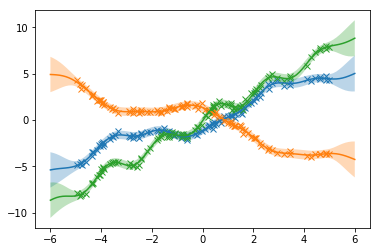

In [7]:
plot_model(m)

In [8]:
def vimshow(K):
    vmax = np.abs(K).max()
    plt.imshow(K, cmap='RdBu_r', vmin=-vmax, vmax=vmax)

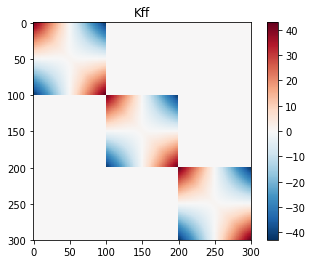

In [9]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
vimshow(np.reshape(K_trans, [100 * 3, 100*3]))
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, and the same kernel is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Shared Independent MOK & Shared Independent Features

We will use the same kernel to model each of the output dimensions.
We will use the same inducing inputs in each of the approximations.

In [10]:
kernel = mk.SharedIndependentMok(gpf.kernels.RBF(1) + gpf.kernels.Linear(1), P)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [11]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional: SharedIndependentMof - SharedIndepedentMok
False False
Kuu: SharedIndependentMof - SharedIndependentMok
Kuf: SharedIndependentMof - SharedIndependentMok
base conditional


In [12]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 49.912192
  Number of iterations: 1501
  Number of functions evaluations: 1605


Conditional: SharedIndependentMof - SharedIndepedentMok
False False
Kuu: SharedIndependentMof - SharedIndependentMok
Kuf: SharedIndependentMof - SharedIndependentMok
base conditional


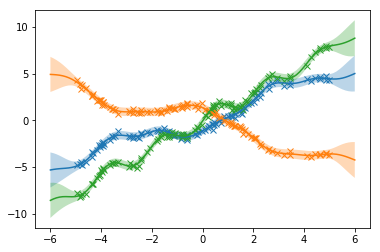

In [13]:
plot_model(m)

Again, same kernel used for each output dimension and the outputs are uncorrelated. In the `conditional`, however, we explicitly use the block-diagonal structure.

## Separate Independent MOK & Shared Independent Features (SLOW CODE)

In [14]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [15]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feature, q_mu=q_mu, q_sqrt=q_sqrt)

Conditional: InducingPoints -- Mok
Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


In [15]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 49.540682
  Number of iterations: 1501
  Number of functions evaluations: 1578


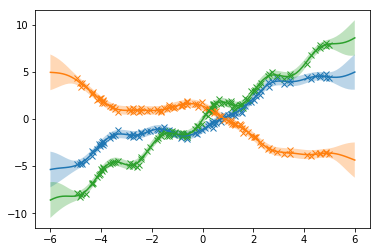

In [16]:
plot_model(m)

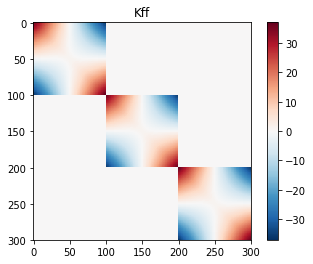

In [17]:
K = (kernel.compute_K_symm(pX))
K_trans = np.transpose(K, [1, 0, 3, 2])
vimshow(np.reshape(K_trans, [100 * 3, 100*3]));
plt.colorbar();
plt.title("Kff");

All the outputs are uncorrelated, *but a different kernel* is used for each output. However, during the `conditional` calculations we do not assume this particular block-diagonal structure. 

## Separate Independent MOK & Shared Independent Features

In [18]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [19]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


In [20]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 55.116299
  Number of iterations: 1501
  Number of functions evaluations: 1799


Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


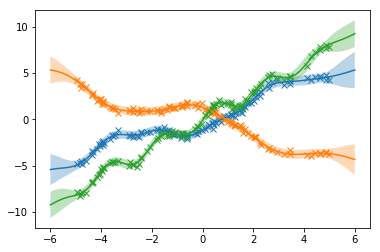

In [21]:
plot_model(m)

In [22]:
m.compute_log_likelihood()

-55.11629898369668

## Separate Independent Kernel & Separate Independent Features

In [23]:
kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(1) for _ in range(P)]
kernel = mk.SeparateIndependentMok(kern_list)
feature_list = [gpf.features.InducingPoints(X[np.random.permutation(len(X))[:M],...].copy()) for _ in range(P)]
feature = mf.SeparateIndependentMof(feature_list)

In [24]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


In [25]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 67.682607
  Number of iterations: 1350
  Number of functions evaluations: 1444


Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


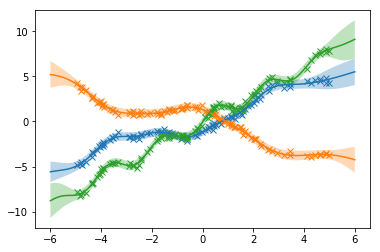

In [26]:
plot_model(m)

Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
base conditional


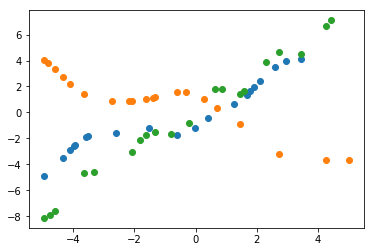

In [27]:
for i in range(len(m.feature.feat_list)):
    q_mu_unwhitenede, q_var_unwhitened = m.predict_f(m.feature.feat_list[i].Z.value)
    plt.plot(m.feature.feat_list[i].Z.value, q_mu_unwhitenede[:, [i]], "o")

This plot shows that we use different inducing *inputs* in each output dimension.

# Mixed Kernel

## 1. Mixed Kernel & Correlated features (SLOW)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
In this scenario we ignore the fact that observations are produced by mixing uncorrelated latent GPs. We directly model the correlated observations. This means that we place our inducing outputs in the $f$ space and end up with the following (large) correlation matrices.

- $ K_{uu} = M \times P \times M  \times P $
- $ K_{uf} = M \times P \times N \times P $

We'll have to use `fully_correlated_conditional` or `base_conditional` depending on the `full_cov`/`full_cov_output` args.

In [28]:
q_mu = np.zeros((M, P)).reshape(M * P, 1)
q_sqrt = np.eye(M * P).reshape(1, M * P, M * P)

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L))
feature = gpf.features.InducingPoints(X[:M,...].copy())

In [29]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

Conditional: InducingPoints -- Mok
Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


In [30]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER);

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 13.443127
  Number of iterations: 1501
  Number of functions evaluations: 1623


Conditional: InducingPoints -- Mok
Kuu: InducingPoints - Mok
Kuf: InducingPoints - Mok
base conditional


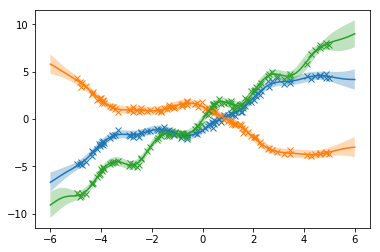

In [31]:
plot_model(m)

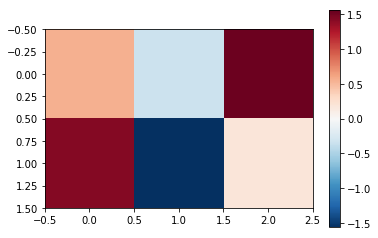

In [32]:
vimshow(m.kern.W.value.T)
plt.colorbar()

## 2. Mixed Kernel & Uncorrelated features (BETTER)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
In this scenario we assume that are inducing outputs live in the $g$ (i.e. $\mathbb{R}^L$) space.


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = M \times L \times N \times P $

We'll use `independent_latents_conditional`

In [33]:
q_mu = np.zeros((M, L))
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=Ptrue.T)
feature = mf.SharedIndependentMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [34]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

Conditional: (SharedIndependentMof, SeparateIndepedentMof) - SeparateMixedMok
independent_interdomain_conditional


In [35]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 15.373198
  Number of iterations: 1501
  Number of functions evaluations: 1691


Conditional: (SharedIndependentMof, SeparateIndepedentMof) - SeparateMixedMok
independent_interdomain_conditional


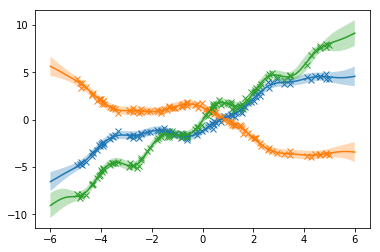

In [36]:
plot_model(m)

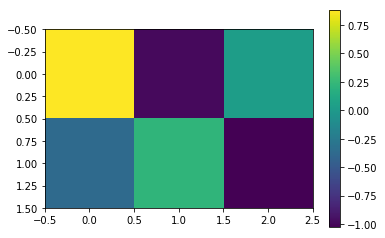

In [37]:
plt.imshow(m.kern.W.value.T)
plt.colorbar()

## 3. Mixed Kernel & Uncorrelated features (OPTIMAL)

Remember: $f(x) = W g(x)$, where $g(x) \in \mathbb{R}^L$, $f(x) \in \mathbb{R}^P$ and $W \in \mathbb{R}^{P \times L}$.
We assume that the outputs of $g$ are uncorrelated, and by *mixing* them with $W$ they become correlated.
With this setup we perform the optimal routine to calculate the conditional. Namely, calculate the conditional of the uncorrelated latent $g$ and afterwards project the mean and variance using the mixing matrix: $\mu_f = W \mu_g$ and $\Sigma_f = W~\Sigma_g W^\top$


- $ K_{uu} = L \times M \times M $
- $ K_{uf} = L \times M \times N $

We'll use `base_conditional`

In [38]:
q_mu = np.zeros((M, L))
q_sqrt = np.repeat(np.eye(M)[None, ...], L, axis=0) * 1.0

kern_list = [gpf.kernels.RBF(D) + gpf.kernels.Linear(D) for _ in range(L)]
kernel = mk.SeparateMixedMok(kern_list, W=np.random.randn(P, L))
feature = mf.MixedKernelSharedMof(gpf.features.InducingPoints(X[:M,...].copy()))

In [39]:
m = gpf.models.SVGP(X, Y, kernel, gpf.likelihoods.Gaussian(), feat=feature, q_mu=q_mu, q_sqrt=q_sqrt)

conditional: MixedKernelSharedMof, SeparateMixedMok
Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
Kuu: MixedKernelSharedMof, SeparateMixedMok
Kuf: MixedKernelSharedMof, SeparateMixedMok
base conditional


In [40]:
opt = gpf.train.ScipyOptimizer()
opt.minimize(m, disp=True, maxiter=MAXITER)

INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: 14.089764
  Number of iterations: 1501
  Number of functions evaluations: 1628


conditional: MixedKernelSharedMof, SeparateMixedMok
Conditional
object, SharedIndependentMof, SeparateIndependentMok, object
object, SeparateIndependentMof, SharedIndependentMok, object
object, SeparateIndependentMof, SeparateIndependentMok, object
Kuu: MixedKernelSharedMof, SeparateMixedMok
Kuf: MixedKernelSharedMof, SeparateMixedMok
base conditional


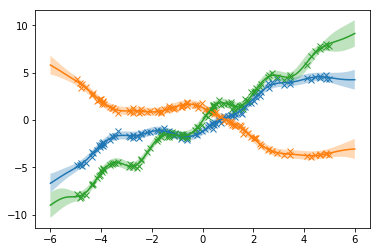

In [41]:
plot_model(m)